# GANs and Diffusion Models


Имя, Фамилия:



---

В этом задании вы обучите генеративно-состязательную и диффузионную модели на датасете [Fashion Mnist](https://github.com/zalandoresearch/fashion-mnist). *Hope you'll enjoy it!*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

## Задание 1: GAN (5 баллов)

1. Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) \([From GAN to WGAN](https://lilianweng.github.io/posts/2017-08-20-gan/)\), используя weight clipping (2 балла);

2. Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf) (1 балл);

3. Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf) (2 балла);

4. Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? **Каждый пункт обязательно сопроводите визуализациями**.

In [22]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 2
config.num_epochs = 20
config.noise_size = 50
config.print_freq = 100

In [23]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [26]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [27]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [28]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, 1))
real_label = 1
fake_label = 0

In [29]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        images = images.to(device)
        label = torch.full((images.size(0), 1), real_label, dtype=torch.float, device=device)
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        # fake
        noise = torch.randn(images.size(0), config.noise_size, device=device)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.16 errD_z: 0.10 errG: 2.50
Epoch:1 Iter: 200 errD_x: 0.18 errD_z: 0.13 errG: 2.80
Epoch:1 Iter: 300 errD_x: 0.11 errD_z: 0.15 errG: 2.36
Epoch:1 Iter: 400 errD_x: 0.14 errD_z: 0.07 errG: 2.68
Epoch:1 Iter: 500 errD_x: 0.03 errD_z: 0.09 errG: 2.75
Epoch:1 Iter: 600 errD_x: 0.10 errD_z: 0.04 errG: 3.25
Epoch:1 Iter: 700 errD_x: 0.00 errD_z: 0.13 errG: 2.30
Epoch:1 Iter: 800 errD_x: 0.44 errD_z: 0.21 errG: 2.10
Epoch:1 Iter: 900 errD_x: 0.06 errD_z: 0.22 errG: 1.98
Epoch:1 Iter: 1000 errD_x: 0.43 errD_z: 0.20 errG: 1.95
Epoch:1 Iter: 1100 errD_x: 0.25 errD_z: 0.13 errG: 2.47
Epoch:1 Iter: 1200 errD_x: 0.34 errD_z: 0.30 errG: 1.96
Epoch:1 Iter: 1300 errD_x: 0.31 errD_z: 0.15 errG: 2.17
Epoch:1 Iter: 1400 errD_x: 0.22 errD_z: 0.18 errG: 2.11
Epoch:1 Iter: 1500 errD_x: 0.20 errD_z: 0.16 errG: 2.50
Epoch:1 Iter: 1600 errD_x: 0.17 errD_z: 0.17 errG: 2.57
Epoch:1 Iter: 1700 errD_x: 0.03 errD_z: 0.24 errG: 2.31
Epoch:1 Iter: 1800 errD_x: 0.03 errD_z: 0.13 errG: 3.03
E

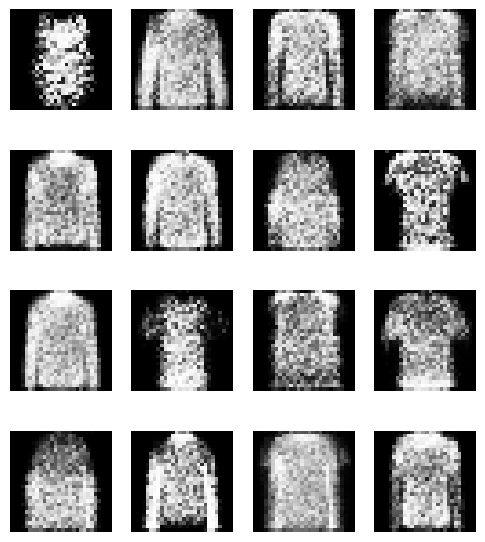

In [30]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].cpu().detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

WGAN

In [62]:
class Generator_WGAN(nn.Module):
    def __init__(self):
        super(Generator_WGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator_WGAN(nn.Module):
    def __init__(self):
        super(Discriminator_WGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
    def forward(self, x):
        return self.model(x)

In [63]:
generator = Generator_WGAN().to(device)
discriminator = Discriminator_WGAN().to(device)

In [64]:
ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
optim_G_W = optim.RMSprop(generator.parameters(), lr=0.0001)
optim_D_W = optim.RMSprop(discriminator.parameters(), lr=0.0001)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        images = images.to(device)
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = - torch.mean(output)

        # fake
        noise = torch.randn(images.size(0), config.noise_size, device=device)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = torch.mean(output)
        loss = errD_x + errD_z
        ERRD[epoch] += loss.item()
        loss.backward()

        optim_D_W.step()

        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        output = discriminator(fake)
        errG = - torch.mean(output)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G_W.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                       iteration+1,
                                                                       loss.item(),
                                                                       errG.item()))

Epoch:1 Iter: 100 errD: -0.11 errG: 0.10
Epoch:1 Iter: 200 errD: -0.12 errG: 0.15
Epoch:1 Iter: 300 errD: -0.11 errG: 0.16
Epoch:1 Iter: 400 errD: -0.09 errG: 0.10
Epoch:1 Iter: 500 errD: -0.10 errG: -0.00
Epoch:1 Iter: 600 errD: -0.12 errG: -0.03
Epoch:1 Iter: 700 errD: -0.10 errG: -0.01
Epoch:1 Iter: 800 errD: -0.11 errG: 0.01
Epoch:1 Iter: 900 errD: -0.06 errG: -0.04
Epoch:1 Iter: 1000 errD: -0.05 errG: -0.04
Epoch:1 Iter: 1100 errD: -0.02 errG: -0.01
Epoch:1 Iter: 1200 errD: -0.01 errG: -0.01
Epoch:1 Iter: 1300 errD: -0.06 errG: -0.01
Epoch:1 Iter: 1400 errD: -0.05 errG: 0.03
Epoch:1 Iter: 1500 errD: -0.02 errG: -0.00
Epoch:1 Iter: 1600 errD: -0.03 errG: 0.02
Epoch:1 Iter: 1700 errD: -0.04 errG: 0.02
Epoch:1 Iter: 1800 errD: -0.03 errG: 0.01
Epoch:1 Iter: 1900 errD: -0.05 errG: 0.01
Epoch:1 Iter: 2000 errD: -0.03 errG: 0.01
Epoch:1 Iter: 2100 errD: -0.03 errG: -0.01
Epoch:1 Iter: 2200 errD: -0.05 errG: 0.01
Epoch:1 Iter: 2300 errD: -0.05 errG: -0.01
Epoch:1 Iter: 2400 errD: -0.04 e

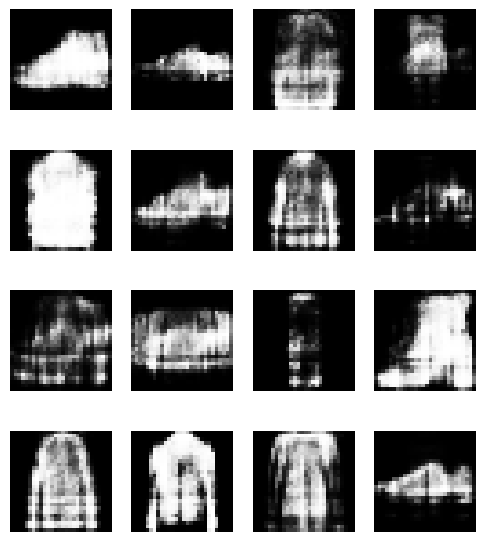

In [65]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].cpu().detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Gradient Penalty:

In [71]:
generator = Generator_WGAN().to(device)
discriminator = Discriminator_WGAN().to(device)

In [72]:
ERRD_GP = np.zeros(config.num_epochs)
ERRG_GP = np.zeros(config.num_epochs)
N = len(dataloader)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
lamda = 10

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        images = images.to(device)
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = - torch.mean(output)

        # fake
        noise = torch.randn(images.size(0), config.noise_size, device=device)
        fake = generator(noise)
        label.data.fill_(fake_label)
        fake_output = discriminator(fake.detach())
        errD_z = torch.mean(fake_output)
        eps = torch.rand(images.size(0), 1, device=device)
        x_hat = (eps * input_data + (1 - eps) * fake).requires_grad_(True)
        D_x = discriminator(x_hat)
        gradients = torch.autograd.grad(outputs=D_x, inputs=x_hat, 
                                        grad_outputs=torch.ones(D_x.size(), device=device),
                                        create_graph=True, retain_graph=True)[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        loss = errD_x + errD_z + lamda * gradient_penalty
        ERRD_GP[epoch] += loss.item()
        loss.backward(retain_graph=True)

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        fake = generator(noise)
        generator.zero_grad()
        output = discriminator(fake)
        errG = - torch.mean(output)
        ERRG_GP[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} Loss: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                       iteration+1,
                                                                       loss.item(),
                                                                       errG.item()))

Epoch:1 Iter: 100 Loss: -1.95 errG: 1.27
Epoch:1 Iter: 200 Loss: -4.12 errG: 4.00
Epoch:1 Iter: 300 Loss: -4.00 errG: 6.60
Epoch:1 Iter: 400 Loss: -2.21 errG: 3.92
Epoch:1 Iter: 500 Loss: -3.09 errG: -0.92
Epoch:1 Iter: 600 Loss: -4.03 errG: -0.60
Epoch:1 Iter: 700 Loss: -3.43 errG: -0.47
Epoch:1 Iter: 800 Loss: -3.41 errG: -0.55
Epoch:1 Iter: 900 Loss: -2.94 errG: -0.72
Epoch:1 Iter: 1000 Loss: -3.22 errG: -2.05
Epoch:1 Iter: 1100 Loss: -2.37 errG: -1.38
Epoch:1 Iter: 1200 Loss: -3.00 errG: -2.14
Epoch:1 Iter: 1300 Loss: -2.95 errG: -0.97
Epoch:1 Iter: 1400 Loss: -2.11 errG: -1.65
Epoch:1 Iter: 1500 Loss: -2.30 errG: 0.08
Epoch:1 Iter: 1600 Loss: -1.97 errG: -1.83
Epoch:1 Iter: 1700 Loss: -1.92 errG: -1.58
Epoch:1 Iter: 1800 Loss: -1.75 errG: -1.51
Epoch:1 Iter: 1900 Loss: -1.94 errG: -1.93
Epoch:1 Iter: 2000 Loss: -2.21 errG: -1.55
Epoch:1 Iter: 2100 Loss: -2.12 errG: -1.70
Epoch:1 Iter: 2200 Loss: -1.76 errG: -1.54
Epoch:1 Iter: 2300 Loss: -1.31 errG: -1.32
Epoch:1 Iter: 2400 Loss: 

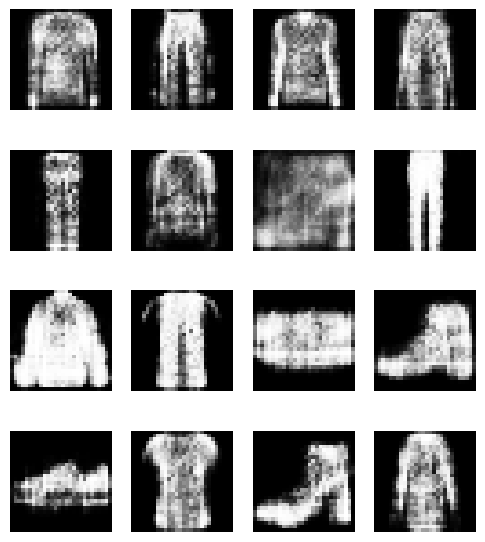

In [74]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].cpu().detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Conditional WGAN:

In [114]:
class C_Generator_WGAN(nn.Module):
    def __init__(self):
        super(C_Generator_WGAN, self).__init__()
        self.label_embbedings = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(config.noise_size + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class C_Discriminator_WGAN(nn.Module):
    def __init__(self):
        super(C_Discriminator_WGAN, self).__init__()
        self.label_embbedings = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
    def forward(self, x):
        return self.model(x)

In [115]:
generator = C_Generator_WGAN().to(device)
discriminator = C_Discriminator_WGAN().to(device)

In [116]:
optim_CG = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_CD = optim.Adam(params=discriminator.parameters(), lr=0.0001)

In [117]:
ERRCD = np.zeros(config.num_epochs)
ERRCG = np.zeros(config.num_epochs)
N = len(dataloader)
lamda = 10

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        images = images.to(device)
        cat = cat.to(device)
        label = torch.full((images.size(0), 1), real_label, dtype=torch.float, device=device)
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        emb = discriminator.label_embbedings(cat)
        input_data_c = torch.cat([input_data, emb], 1)
        output = discriminator(input_data_c)
        errD_x = - torch.mean(output)
        # fake
        noise = torch.randn(images.size(0), config.noise_size, device=device)
        fake_label = torch.randint(0, 10, tuple([images.size(0)])).to(device)
        fake_emb_gen = generator.label_embbedings(fake_label)
        noise_c = torch.cat([noise, fake_emb_gen], 1)
        fake = generator(noise_c)
        fake_emb = discriminator.label_embbedings(fake_label)
        fake_input = torch.cat([fake.detach(), fake_emb], 1)
        fake_output = discriminator(fake_input)
        errD_z = torch.mean(fake_output)
        eps = torch.rand(images.size(0), 1, device=device)
        x_hat = (eps * input_data_c + (1 - eps) * fake_input).requires_grad_(True)
        D_x = discriminator(x_hat)
        gradients = torch.autograd.grad(outputs=D_x, inputs=x_hat, 
                                        grad_outputs=torch.ones(D_x.size(), device=device),
                                        create_graph=True, retain_graph=True)[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        loss = errD_x + errD_z + lamda * gradient_penalty
        ERRCD[epoch] += loss.item()
        loss.backward()

        optim_CD.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        noise = torch.randn(images.size(0), config.noise_size, device=device)
        fake_label = torch.randint(0, 10, tuple([images.size(0)])).to(device)
        fake_emb_gen = generator.label_embbedings(fake_label)
        noise_c = torch.cat([noise, fake_emb_gen], 1)
        fake = generator(noise_c)
        fake_emb = discriminator.label_embbedings(fake_label)
        fake_input = torch.cat([fake, fake_emb], 1)
        output = discriminator(fake_input)
        errG = - torch.mean(output)
        ERRCG[epoch] += errG.item()
        errG.backward()

        optim_CG.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} Loss: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                       iteration+1,
                                                                       loss.item(),
                                                                       errG.item()))

Epoch:1 Iter: 100 Loss: -3.34 errG: 2.39
Epoch:1 Iter: 200 Loss: -4.31 errG: 5.27
Epoch:1 Iter: 300 Loss: -2.34 errG: 5.58
Epoch:1 Iter: 400 Loss: -2.78 errG: 1.24
Epoch:1 Iter: 500 Loss: -3.33 errG: -1.98
Epoch:1 Iter: 600 Loss: -2.42 errG: -0.43
Epoch:1 Iter: 700 Loss: -2.29 errG: -1.17
Epoch:1 Iter: 800 Loss: -1.89 errG: -0.82
Epoch:1 Iter: 900 Loss: -2.48 errG: -0.25
Epoch:1 Iter: 1000 Loss: -1.84 errG: -1.64
Epoch:1 Iter: 1100 Loss: -2.34 errG: 0.39
Epoch:1 Iter: 1200 Loss: -2.58 errG: 0.07
Epoch:1 Iter: 1300 Loss: -2.13 errG: -1.62
Epoch:1 Iter: 1400 Loss: -3.07 errG: -0.27
Epoch:1 Iter: 1500 Loss: -2.46 errG: -1.43
Epoch:1 Iter: 1600 Loss: -2.92 errG: 0.08
Epoch:1 Iter: 1700 Loss: -2.79 errG: -0.68
Epoch:1 Iter: 1800 Loss: -3.51 errG: -0.52
Epoch:1 Iter: 1900 Loss: -2.85 errG: -1.50
Epoch:1 Iter: 2000 Loss: -3.40 errG: -1.25
Epoch:1 Iter: 2100 Loss: -2.85 errG: -0.53
Epoch:1 Iter: 2200 Loss: -2.86 errG: -0.49
Epoch:1 Iter: 2300 Loss: -2.84 errG: -1.71
Epoch:1 Iter: 2400 Loss: -2

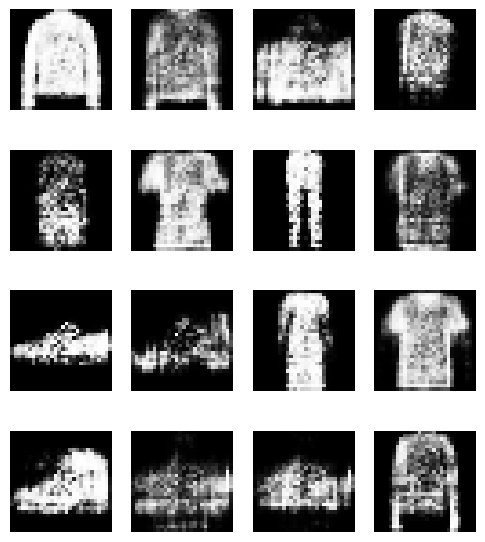

In [118]:
noise.data.normal_(0, 1)
fake_emb_gen = generator.label_embbedings(torch.IntTensor(np.random.randint(0, 10, config.batch_size)).to(device))
noise_c = torch.cat([noise, fake_emb_gen], 1)
fake = generator(noise_c)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].cpu().detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Вывод:
1) Использование WGAN приводит к более быстрой сходимости к точке равновесия, так как за равное число эпох (20), для данных полученных из генератора WGAN получились более четкие изображения, больше напоминающие реальные.
2) Качество изображений, полученных при использовании генератора модели WGAN с gradient penalty вместо weight clipping не так резко отличается, как результаты обучения GAN и WGAN с wheight clipping, но улучшение есть, больше деталей можно разглядеть на сгенерированных изображениях.
3) Генератор Conditional WGAN дает еще более четкие изображения.



---



## Задание 2: Diffusion Model (5 баллов)

1. Скачайте репозиторий:

    ```
    git clone https://github.com/awjuliani/pytorch-diffusion.git
    ```

2. Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл);

3. Добавьте к обучению DDPM условие на метку с помощью [Classifier Free Guidance](https://arxiv.org/abs/2207.12598) (2 балла);

4. Обучите модель в режиме inpainting \([параграф 4.1](https://arxiv.org/pdf/2201.09865.pdf)\) (2 балла);

5. Опишите проведенные эксперименты и полученные выводы.



---



# Домашнее задание № 8

Выполните все задания в этом ноутбуке.

Решение без отчета (текстового описания) будет оценено в 0 баллов.

+ Мягкий дедлайн: `02.04.25 23:59`
+ Жесткий дедлайн: `09.04.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.